# Imports

In [1]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score

import torch
from torch.utils.data import DataLoader
import torch.nn as nn
from torch.optim import Adam
from torch.utils.data import DataLoader


from __future__ import annotations
from IPython.display import clear_output 
from matplotlib import pyplot as plt
import random
from queue import Queue
from tqdm import tqdm
import pandas as pd
import numpy as np
import gensim
import gc

import fasttext.util
from wikipedia2vec import Wikipedia2Vec
fasttext.util.download_model('ru', if_exists='ignore')

import nltk
# nltk.download('stopwords')
# nltk.download('punkt')
from nltk.corpus import stopwords
from nltk.tokenize import wordpunct_tokenize, word_tokenize
from nltk.stem import SnowballStemmer

import natasha
import pymorphy2

ROOT_ID = 1
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [8]:
SEED = 42

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

# Data Analysis

## Tables

### Products

In [4]:
products = pd.read_parquet('train.parquet')

In [ ]:
products.sample(3)

,id,title,short_description,name_value_characteristics,rating,feedback_quantity,category_id
154781,1261155,Комплект снуд в один оборот и шапка на флисе Ж...,Зимний комплект снуд и шапка на флисе,None,0.0,0,12071
19453,1136598,Подвеска женская сердце с черным камнем/женско...,None,None,5.0,9,12579
147554,625069,"Ремень женский с круглой пряжкой из экокожи ""...",None,None,0.0,0,13486


In [ ]:
products.shape

(283452, 7)

In [ ]:
products['category_id'].value_counts().shape

(1231,)

In [ ]:
products['category_id'].value_counts()

11937    14967
13408     7153
13061     6434
13143     6145
13407     3390
         ...  
2685         2
13626        2
14542        2
13007        2
13238        2
Name: category_id, Length: 1231, dtype: int64

As we can see, we have products from 1231 different categories

In [ ]:
products[products['short_description'] == 'None'].shape

(1691, 7)

In [ ]:
products[products['short_description'] == 'None'][:3]

,id,title,short_description,name_value_characteristics,rating,feedback_quantity,category_id
203,532874,Худи Puma Logo Sweat Jacket,None,None,0.0,0,11774
205,946590,"Открытка ""Голуби""",None,None,0.0,0,11790
582,933287,Увлажняющий тональный крем с коллагеном (100мл),None,Тон:13|21,5.0,1,12439


Only a small number of products does not have a description.

In [ ]:
products[products['title'] == '']

,id,title,short_description,name_value_characteristics,rating,feedback_quantity,category_id
277112,1428312,,None,None,0.0,0,13143


There is one product with missing information. It should be deleted.

In [5]:
products.drop(277112, inplace=True)

### Categories

In [6]:
categories = pd.read_csv('categories_tree.csv')

In [ ]:
categories.shape

(3370, 3)

In [ ]:
categories.head(5)

,id,title,parent_id
0,1,Все категории,0
1,114,Урбеч,1913
2,115,Варенье и джемы,328
3,128,Сухие завтраки,2475
4,131,Масла,2475


In [ ]:
categories[categories['parent_id'] == 0]

,id,title,parent_id
0,1,Все категории,0
21,553,Травяные сборы,0
23,1754,Табак,0
28,2000,Игры и софт,0


In [ ]:
categories[(categories['id'] == 0) |
           (categories['parent_id'] == 553) |
           (categories['parent_id'] == 1754) |
           (categories['parent_id'] == 2000)]

,id,title,parent_id


The `root category` has `id = 1` but there are some categories that have `parent_id = 0`. Such categories does not have children and are not included in the main category tree.

In [ ]:
ROOT_ID = 1

In [ ]:
# Base categories
categories[categories['parent_id'] == 1]

,id,title,parent_id
24,1821,Продукты питания,1
324,10002,Автотовары,1
325,10003,Аксессуары,1
326,10004,Бытовая техника,1
327,10005,Бытовая химия и личная гигиена,1
328,10006,"Дача, сад и огород",1
329,10007,Детские товары,1
330,10008,Хобби и творчество,1
331,10009,Здоровье,1
332,10010,Канцтовары,1


## Category Tree

In [ ]:
class Category():
    '''Represents node for tree structure of categories.
    '''
    def __init__(self, id):
        self.id = id
        self.subcategories = []

    def add_subcategory(self, sub: Category):
        self.subcategories.append(sub)

In [ ]:
def create_category_tree(
        categories: pandas.core.frame.DataFrame,
        root_id: int
        ) -> dict[int, Category]:
    '''Starts from the root node and creates the category tree.
    '''
    cat_dict = {root_id: Category(root_id)}
    queue = Queue()
    queue.put(root_id)
    
    while not queue.empty():
        id = queue.get_nowait()
        
        for child_id in list(categories[categories['parent_id'] == id]['id']):
            child = Category(child_id)
            cat_dict[child_id] = child
            cat_dict[id].add_subcategory(child)
            queue.put(child_id)

    return cat_dict

In [ ]:
# Keeps references of all nodes in category tree
# Key is id of category
cat_dict = create_category_tree(categories, ROOT_ID)

In [ ]:
len(cat_dict)

3347

### Missing Categories

After creation of category tree we get **3347** categories in it but we have **3370** categories in total. We should take care of unreferenced ones.<br>
Some of them are those with `parent_id = 0` but there are others.

In [ ]:
keys = set(cat_dict.keys())
cats = set(categories['id'])
difference = list(cats - keys)
missing_cat = categories[categories['id'].isin(difference)]
missing_cat

,id,title,parent_id
21,553,Травяные сборы,0
23,1754,Табак,0
28,2000,Игры и софт,0
225,2780,Кальяны и аксессуары,2779
226,2781,Товары для самокруток,2779
227,2782,Пепельницы,2779
228,2783,Портсигары и хьюмидоры,2779
229,2784,Бонги и аксессуары,2779
230,2785,Подарочные наборы для курения,2779
231,2786,Смеси для кальяна,2780


In [ ]:
products[products['category_id'].isin(list(missing_cat['id']))]

,id,title,short_description,name_value_characteristics,rating,feedback_quantity,category_id


As we can see, there are no products from the missing categories in the table. The constructed categories tree is sufficient.

### Leaf or not Leaf
Now I want to check if all the products belong to the leaf categories

In [ ]:
def find_leaf_and_branch_categories(root_node: Category):
    leafs = set()
    branches = set()
    queue = Queue()
    queue.put(root_node)
    
    while not queue.empty():
        node = queue.get_nowait()
        if len(node.subcategories) == 0:
            leafs.add(node.id)
        else:
            branches.add(node.id)
            for child in node.subcategories:
                queue.put(child)
    
    return  leafs, branches

In [ ]:
leafs, branches = find_leaf_and_branch_categories(cat_dict[1])
np.save('leafs', list(leafs))
np.save('branches', list(branches))
len(leafs)

2825

In [ ]:
len(set(products['category_id']))

1231

In [ ]:
len(leafs & set(products['category_id']))

1231

As we can see, the categories of all products are leaf categories.<br>
We can also make another observation: the total number of possible categories is twice as large as the set of categories from the product table.<br>

In [ ]:
len(branches)

522

We have 522 branch nodes. This is the bumber of classifiers that I need to train.

# Data preparation

## Dataset Representation
I represent dataset as a tree structure. Branch nodes generate labled dataset for each corresponding classifier and leaf nodes contain lists with data to path to branch nodes.

In [158]:
class Node():
    def __init__(self, id):
        self.id = id

    def get_products(self):
        pass


class BranchNode(Node):
    def __init__(self, id):
        super().__init__(id)
        self.subcategories = []
    
    def add_subcategory(self, category: Node):
        self.subcategories.append(category)

    def get_products(self):
        products = None
        for subcategory in self.subcategories:
            id, prod = subcategory.get_products()

            if products is None:
                products = prod
            elif prod is not None:
                products = np.append(products, prod, axis=0)

        return self.id, products

    def get_dataset(self):
        prod_id = None
        prod_emb = None
        for subcategory in self.subcategories:
            id, products = subcategory.get_products()

            if products is not None:

                if prod_id is None:
                    prod_id = [id] * len(products)
                    prod_emb = products
                else:
                    prod_id = np.concatenate((prod_id, [id] * len(products)))
                    prod_emb = np.append(prod_emb, products, axis=0)

        return prod_emb, prod_id


class LeafNode(Node):
    def __init__(self, id):
        super().__init__(id)
        self.products = None

    def add_product(self, product):
        if self.products is None:
            self.products = [product]
        else:
            self.products = np.append(self.products, [product], axis=0)

    def get_products(self):
        return self.id, self.products

In [14]:
def create_dataset_tree(
        root_id,
        categories: pandas.core.frame.DataFrame,
        leafs,
        branches):
    '''Starts from the root node and creates dataset tree.
    '''
    dataset_dict = {root_id: BranchNode(root_id)}
    queue = Queue()
    queue.put(root_id)

    while not queue.empty():
        id = queue.get_nowait()
        
        for child_id in list(categories[categories['parent_id'] == id]['id']):
            if child_id in leafs or child_id in branches:
                child = LeafNode(child_id) if child_id in leafs else BranchNode(child_id)
                dataset_dict[child_id] = child
                dataset_dict[id].add_subcategory(child)
                queue.put(child_id)

    return dataset_dict

In [15]:
branches = np.load('branches.npy', allow_pickle=True)
leafs = np.load('leafs.npy', allow_pickle=True)
dataset_dict = create_dataset_tree(ROOT_ID, categories, leafs, branches)

In [16]:
def fill_dataset_with_products(dataset_dict, products, ids):
    for product, id in tqdm(zip(products, ids)):
        try:
            dataset_dict[id].add_product(product)
        except:
            print(id)
            break

## Tokenization
At first we need to find best way to tokenize our titles and descriptions.<br>
I will compare lemmatization from [**Natasha**](https://natasha.github.io/), stemming from **nltk** and lemmatization from **pymorphy2**

In [ ]:
list(products['title'])[:3]

['Muhle Manikure Песочные колпачки для педикюра 1015 PW Средний (150 грит) (упаковка 10 шт)',
 'Sony Xperia L1 Защитное стекло 2,5D',
 'Конверт для денег Прекрасная роза, 16,5 х 8 см']

In [ ]:
list(products['short_description'])[:3]

['Muhle Manikure Колпачок песочный шлифовальный для педикюра 1015 PW Белый Средний (150 грит) (упаковка 10 шт)',
 None,
 'Конверт для денег «Прекрасная роза», 16,5 × 8 см']

In [ ]:
stop_words = stopwords.words("russian")
stop_words += ['.', ',', '"', '!',
                 '?','(', ')', '-',
                 ':', ';', '_', '\\']

In [ ]:
segmenter = natasha.Segmenter()
nat_emb = natasha.NewsEmbedding()
morph_tagger = natasha.NewsMorphTagger(nat_emb)
morph_vocab = natasha.MorphVocab()


def natasha_tokenize(text):
    doc = natasha.Doc(text)
    doc.segment(segmenter)
    doc.tag_morph(morph_tagger)
    for token in doc.tokens:
        token.lemmatize(morph_vocab)
    tokens = [_.lemma for _ in doc.tokens if _.lemma not in stop_words]
    return tokens

In [ ]:
def nltk_tokenize(text):
    tokens = word_tokenize(text, language="russian")
    filtered_tokens = []
    for token in tokens:
        if token not in stop_words:
            filtered_tokens.append(token)

    return filtered_tokens


snowball = SnowballStemmer(language="russian")

def nltk_stem(text):
    stemmed_tokens = []
    for token in nltk_tokenize(text):
        stemmed_tokens.append(snowball.stem(token))
    return stemmed_tokens


morph = pymorphy2.MorphAnalyzer()

def pymorphy_lem(text):
    lemmatized_tokens = []
    for token in nltk_tokenize(text):
        lemmatized_tokens.append(morph.parse(token)[0].normal_form)
    
    return lemmatized_tokens

In [ ]:
def check_dictionary_coverage(corpus, emb_dict, tok_func):
    number = 0
    sum = 0
    missing = []
    for sent in corpus:
        tokens = tok_func(sent)
        for token in tokens:
            if token in emb_dict:
                sum += 1
            else:
                missing.append(token)
            number += 1

    return sum / number, missing

In [ ]:
# fasttext embeddings
ft = fasttext.load_model('cc.ru.300.bin')

In [ ]:
natasha_coverage, _ = check_dictionary_coverage(products['title'][:100], ft.words, natasha_tokenize)
nltk_coverage, _ = check_dictionary_coverage(products['title'][:100], ft.words, nltk_stem)
pymorphy_coverage, _ = check_dictionary_coverage(products['title'][:100], ft.words, pymorphy_lem)
print('natasha:', natasha_coverage)
print('nltk:', nltk_coverage)
print('pymorhy:', pymorphy_coverage)

natasha: 0.9457831325301205
nltk: 0.75
pymorhy: 0.8710691823899371


As we can see tokenization via **natasha** gives the biggest match with **fasttext** embeddings dictionary.
I will use this tokenization method for futher learning.

## Embeddings
Now I want to choose best embeddings.<br>
I will compare embeddings from **fastext**, **natasha** and [**wikipedia2vec**](https://wikipedia2vec.github.io/wikipedia2vec/pretrained/)

In [ ]:
wiki2vec = Wikipedia2Vec.load('ruwiki_20180420_300d.pkl')

In [ ]:
wiki2vec_dict = []
for word in wiki2vec.dictionary.words():
    wiki2vec_dict.append(word.text)

In [ ]:
fasttext_cov, _ = check_dictionary_coverage(products['title'][:100], ft.words, natasha_tokenize)
natasha_cov, _ = check_dictionary_coverage(products['title'][:100], nat_emb, natasha_tokenize)
wiki2vec_cov, _ = check_dictionary_coverage(products['title'][:100], wiki2vec_dict, natasha_tokenize)
print('fasttext:', fasttext_emb)
print('natasha:', natasha_emb)
print('wiki2vec:', wiki2vec_cov)

fasttext: 0.9457831325301205
natasha: 0.6792168674698795
wiki2vec: 0.8780120481927711


**natasha**'s embeddings are learned on news and does not suit well for our task.<br>
I will use `concatenation of fasttext and wiki2vec embeddings` for our task.

## Data Preparation
Let's generate embeddings for all products in dataset.<br>
I will use arithmetic mean of embeddings of all the words in the sentence as input for fully connected classifier.<br>
We have several columns in products table but only `title` and `short_description` are meaningful for feature extraction.

In [ ]:
def vectorize(token):
    try:
        fast_text_vector = ft.get_word_vector(token)
    except KeyError:
        fast_text_vector = np.zeros((ft.get_dimension()))

    try:
        word2vec_vector = wiki2vec.get_word_vector(token)
    except KeyError:
        word2vec_vector = np.zeros((len(wiki2vec.get_word_vector('word'))))

    return np.concatenate([word2vec_vector, fast_text_vector])


def get_sent_emb(sentence):
    tokens = natasha_tokenize(sentence)
    sent_emb = []
    for token in tokens:
        sent_emb.append(vectorize(token))
        
    return np.mean(sent_emb, axis=0)

In [ ]:
avg_title_emb = []

for title in tqdm(products['title']):
    avg_title_emb.append(get_sent_emb(title))

avg_title_emb = np.array(avg_title_emb)

np.save('avg_title_emb', avg_title_emb)

In [ ]:
avg_title_emb = np.load('avg_title_emb.npy')

Now we have embeddings for all products and we can fill dataset tree with them.

In [ ]:
fill_dataset_with_products(dataset_dict, avg_title_emb, products['category_id'])

283451it [03:17, 1436.42it/s]


# Learning

## Root Classfier
Let's test our method on classification of root categories

In [ ]:
title_emb, ids = dataset_dict[ROOT_ID].get_dataset()

In [ ]:
categories[categories['id'].isin(set(ids))]

,id,title,parent_id
325,10003,Аксессуары,1
334,10012,Красота,1
336,10014,Одежда,1
339,10018,Товары для дома,1
341,10020,Электроника,1


In [ ]:
unique, counts = np.unique(id, return_counts=True)

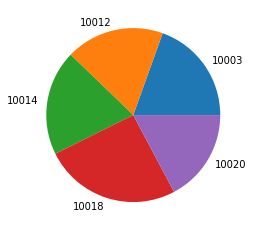

In [ ]:
plt.pie(counts, labels=unique)
plt.show()

As we can see we have products only from five root categories and they are balanced pretty well.

### Data Loaders

In [19]:
def create_labels(ids):
    '''Converts list of product ids into indexes from zero to (len(ids) - 1)

    Returns:
        list of corresponding indexes for given ids
        and dictionry for reverse mapping from index to id
    '''
    unique = np.unique(ids)
    labels = [np.where(unique == id)[0][0] for id in ids]
    labels_dict = {index: id for index, id in enumerate(unique)}
    return labels, labels_dict

In [ ]:
labels, labels_dict = create_labels(ids)

In [ ]:
np.save('./labels_dict/1.npy', labels_dict)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
                                       title_emb, 
                                       labels, 
                                       test_size=0.1, 
                                       random_state=SEED)

In [ ]:
batch_size = 32
num_workers = 2

train_loader = DataLoader(list(zip(X_train, y_train)), 
                          batch_size=batch_size, 
                          num_workers=num_workers, 
                          shuffle=True, 
                          drop_last=True)

valid_loader = DataLoader(list(zip(X_test, y_test)), 
                          batch_size=batch_size, 
                          num_workers=num_workers, 
                          shuffle=False, 
                          drop_last=True)

### Learning

In [18]:
def train_model(
        model, 
        model_id, # Category id corresponding to this model 
        train_loader, 
        valid_loader,
        num_epochs=10):
    
    model.double()
    model = model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.AdamW(model.parameters())

    loaders = {"train": train_loader, "valid": valid_loader}
    accuracy = {"train": [], "valid": []}
    best_accuracy = 0


    for epoch in range(num_epochs):
        print(f'\nEpoch: {epoch + 1}')
        for k, dataloader in loaders.items():
            epoch_correct = 0
            epoch_all = 0

            for x_batch, y_batch in dataloader:

                x_batch = x_batch.to(device)
                y_batch = y_batch.to(device)

                if k == "train":
                    model.train()
                    optimizer.zero_grad()
                    outp = model(x_batch)
                else:
                    model.eval()
                    with torch.no_grad():
                        outp = model(x_batch)

                preds = outp.argmax(-1)
                correct = (preds == y_batch).sum()
                all = len(outp)
                epoch_correct += correct.item()
                epoch_all += all

                if k == "train":
                    loss = criterion(outp, y_batch)
                    loss.backward()
                    optimizer.step()

            print(f"Loader: {k}. Accuracy: {round(epoch_correct/epoch_all, 4)}")

            accuracy[k].append(epoch_correct/epoch_all)

            if k == 'valid' and accuracy['valid'][-1] > best_accuracy:
                torch.save(model.state_dict(), f'./models/{model_id}.pt')
                best_accuracy = accuracy['valid'][-1]

    print('\nBest accuracy:\n')
    print('train:', round(max(accuracy['train']), 4))
    print('test:', round(max(accuracy['valid']), 4))
    model.load_state_dict(torch.load(f'./models/{model_id}.pt', map_location=device))
    return round(max(accuracy['train']), 4), round(max(accuracy['valid']), 4)

Here I will try to use different architectures of classificators

In [ ]:
model1 = nn.Sequential(
    nn.BatchNorm1d(600),
    nn.Linear(600, 200),
    nn.BatchNorm1d(200),
    nn.ReLU(),
    nn.Linear(200, 100),
    nn.BatchNorm1d(100),
    nn.ReLU(),
    nn.Linear(100, 50),
    nn.BatchNorm1d(50),
    nn.ReLU(),
    nn.Linear(50, 5)
)

train_model(model1, ROOT_ID, train_loader, valid_loader)

In [ ]:
models = {}

In [ ]:
def test_model(hid_size, model=None, num_epochs=10):
    if model is None: 
        model = nn.Sequential(
            nn.BatchNorm1d(600),
            nn.Linear(600, hid_size),
            nn.BatchNorm1d(hid_size),
            nn.ReLU(),
            nn.Linear(hid_size, 5))

    train, test = train_model(model, f'model{hid_size}', num_epochs)

    return {'model': model,
            'train': train,
            'test': test}

In [ ]:
models[100] = test_model(100)

In [ ]:
for key, value in models.items():
    test = value['test']
    train = value['train']
    print(f'hid_size={key}: test_acc={test}')
    # print(value['test'])

print('\ndeep_model: test acc=0.9602')

hid_size=100: test_acc=0.95763
hid_size=10: test_acc=0.9432
hid_size=15: test_acc=0.9472
hid_size=25: test_acc=0.9526
hid_size=35: test_acc=0.9539
hid_size=50: test_acc=0.9561
hid_size=64: test_acc=0.957

deep_model: test acc=0.9602


In [ ]:
model1.eval()
with torch.no_grad():
    outp = model1(torch.tensor(X_test).to(device))
preds = outp.argmax(-1)

f1_score(y_test, preds.cpu(), average='weighted')

0.9601112269326004

As we can see architecture of `RNN with 3 layers` gives **increase of 0.003** in accuracy compared with `1 layer RNN` with 64 hidden neurons.<br>
As for comparison of number of hidden neurons I concluded that `64 is enough` as it gives `the same result as 100`.<br>
In our case 1 layer RNN does not get overfitted and the most optimal number of epochs is 10.

## Classification Tree
My classifier will have a tree structure with one layer RNN in each branch node.<br>
`predict()` method will be called from root node than root classifier will decide which sub-classifier to call. This process continues until we reach leaf category.<br>
`predict()` method will return all the path through the tree

In [152]:
class ClassNode():
    def __init__(self, id):
        self.id = id
        self.parent = None

    def predict(self, embedding):
        pass


class ClassBranch(ClassNode):
    def __init__(self, id):
        '''Loads pretrained classifier from disc by category id
        '''
        super().__init__(id)
        try:
            self.labels_dict = np.load(f'./labels_dict/{id}.npy', allow_pickle=True).item()

            self.model = nn.Sequential(
                nn.BatchNorm1d(600),
                nn.Linear(600, 64),
                nn.BatchNorm1d(64),
                nn.ReLU(),
                nn.Linear(64, len(self.labels_dict)))
            self.model.load_state_dict(torch.load(f'./models/{id}.pt', map_location='cpu'))
            self.model.double()
            self.model.eval()
        except:
            pass

        self.subcategories = {}

    def predict(self, embedding, path=None):
        with torch.no_grad():
            outp = self.model(torch.tensor(np.expand_dims(embedding, axis=0)))
        pred = int(outp.argmax(-1))
        prod_cat = self.labels_dict[pred]

        if path is None:
            path = []
        else:
            path.append(self.id)
        return self.subcategories[prod_cat].predict(embedding, path)
    
    def add_subcategory(self, category: ClassNode):
        self.subcategories[category.id] = category
        category.parent = self

    def get_parent(self, path):
        '''Help method for get_parents() in ClassLeaf
        Adds parents to the path for a given leaf
        '''
        if self.parent == None:
            return list(reversed(path))
        else:
            path.append(self.id)
            return self.parent.get_parent(path)


class ClassLeaf(ClassNode):
    def __init__(self, id):
        super().__init__(id)
        
    def predict(self, embedding, path: list):
        path.append(self.id)
        return path

    def get_parents(self):
        '''Returns all the path from root to this leaf category
        '''
        return self.parent.get_parent([self.id])

### Train Model

In [52]:
def train_model(
        model, 
        model_id, 
        dataloader,
        num_epochs=10):
    
    model.double()
    model = model.to(device)
    model.train()
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.AdamW(model.parameters())

    accuracy = []
    best_accuracy = 0


    for epoch in range(num_epochs):
        print(f'\nEpoch: {epoch + 1}')
        epoch_correct = 0
        epoch_all = 0

        for x_batch, y_batch in dataloader:

            x_batch = x_batch.to(device)
            y_batch = y_batch.to(device)

            optimizer.zero_grad()
            outp = model(x_batch)

            preds = outp.argmax(-1)
            correct = (preds == y_batch).sum()
            all = len(outp)
            epoch_correct += correct.item()
            epoch_all += all

            loss = criterion(outp, y_batch)
            loss.backward()
            optimizer.step()

        print(f'Accuracy: {round(epoch_correct/epoch_all, 4)}')

        accuracy.append(epoch_correct/epoch_all)

        if accuracy[-1] > best_accuracy:
            torch.save(model.state_dict(), f'./models/{model_id}.pt')
            best_accuracy = accuracy[-1]

    print(f'\nBest accuracy: {round(max(accuracy), 4)}\n')
    model.load_state_dict(torch.load(f'./models/{model_id}.pt', map_location=device))
    return round(max(accuracy), 4)

In [ ]:
# models_stat = {}
# np.save('models_stat', models_stat)
np.load('models_stat.npy', allow_pickle=True).item()

In [ ]:
def create_labels(ids):
    '''Converts list of product ids into indexes from zero to (len(ids) - 1)

    Returns:
        list of corresponding indexes for given ids
        and dictionry for reverse mapping from index to id
    '''
    unique = np.unique(ids)
    labels = [np.where(unique == id)[0][0] for id in ids]
    labels_dict = {index: id for index, id in enumerate(unique)}
    return labels, labels_dict

In [74]:
def train_model_pipe(id, dataset):
    '''Trains Branch classifier for Classification tree
    and saves it's parameters to the disc
    '''
    title_emb, ids = dataset
    labels, labels_dict = create_labels(ids)
    np.save(f'./labels_dict/{id}.npy', labels_dict)

    batch_size = 4 if len(labels) >= 4 else len(labels)
    num_workers = 2

    loader = DataLoader(list(zip(title_emb, labels)), batch_size=batch_size, num_workers=num_workers, shuffle=True, drop_last=True)

    model = nn.Sequential(
                nn.BatchNorm1d(600),
                nn.Linear(600, 64),
                nn.BatchNorm1d(64),
                nn.ReLU(),
                nn.Linear(64, len(labels_dict)))

    acc = train_model(model, id, loader, num_epochs=10)

    models_stat = np.load('models_stat.npy', allow_pickle=True).item()
    models_stat[id] = acc
    np.save('models_stat', models_stat)

### Train Tree

In [31]:
def train_tree(root_node: BranchNode):
    '''Trains all needed classifiers for classification tree
    In our case dataset is incomplete it does not have products for all 
    possible leaf categories. So, this methods trains classifiers only for 
    nonempty categories.

    Args:
        root_node: root node of filled with products dataset tree
    '''
    queue = Queue()
    queue.put(root_node)

    ready = []
    count = 0
    
    while not queue.empty():
        node = queue.get_nowait()

        if type(node) is BranchNode:
            dataset = node.get_dataset()

            if dataset[0] is not None:
                count += 1
                clear_output()
                print(f'Classifier number {count}\n\n')

                train_model_pipe(node.id, dataset)
                ready.append(node.id)
                np.save('ready', ready)

            for child in node.subcategories:
                queue.put(child)

In [25]:
empty = np.load('empty.npy', allow_pickle=True)

In [30]:
len(branches) - len(empty)

245

### Learning

In [2]:
avg_title_emb = np.load('avg_title_emb.npy')

In [9]:
X_train, X_test, y_train, y_test = train_test_split(avg_title_emb, products['category_id'], test_size=0.1, random_state=SEED)

In [17]:
fill_dataset_with_products(dataset_dict, X_train, y_train)

255105it [02:57, 1436.87it/s]


We are having 245 branch nodes with non-empty leafs (they have some products from the table). It means that I need to train 245 classifiers.

In [76]:
train_tree(dataset_dict[ROOT_ID])

Classifier number 245



Epoch: 1
Accuracy: 0.8429

Epoch: 2
Accuracy: 0.9143

Epoch: 3
Accuracy: 0.9429

Epoch: 4
Accuracy: 0.95

Epoch: 5
Accuracy: 0.9429

Epoch: 6
Accuracy: 0.9643

Epoch: 7
Accuracy: 0.9643

Epoch: 8
Accuracy: 0.9786

Epoch: 9
Accuracy: 0.9214

Epoch: 10
Accuracy: 0.9714

Best accuracy: 0.9786



### Assembling the classification tree
Now we have learned all needed RNNs and we can construct classification tree and test it.

In [88]:
def assemble_classification_tree(
        root_id,
        categories: pandas.core.frame.DataFrame,
        leafs,
        branches):
    '''Starts from the root node and creates dataset tree.
    '''
    classification_dict = {root_id: ClassBranch(root_id)}
    queue = Queue()
    queue.put(root_id)

    while not queue.empty():
        id = queue.get_nowait()
        
        for child_id in list(categories[categories['parent_id'] == id]['id']):
            if child_id in leafs or child_id in branches:
                child = ClassLeaf(child_id) if child_id in leafs else ClassBranch(child_id)
                classification_dict[child_id] = child
                classification_dict[id].add_subcategory(child)
                queue.put(child_id)

    return classification_dict

In [155]:
branches = np.load('branches.npy', allow_pickle=True)
leafs = np.load('leafs.npy', allow_pickle=True)
classificator_dict = assemble_classification_tree(ROOT_ID, categories, leafs, branches)

Prediction: from parents to leaf

In [157]:
classificator_dict[ROOT_ID].predict(X_test[0])

[10018, 10118, 10749, 13885]

True leaf category

In [99]:
list(y_test)[0]

13885

True path through the category tree

In [156]:
classificator_dict[13885].get_parents()

[10018, 10118, 10749, 13885]

As we can see first test sample is correct

# Testing


In [133]:
true = [cat_dict[id].get_parents() for id in y_test]

In [129]:
predictions = [classification_dict[ROOT_ID].predict(emb) for emb in X_test]

Let's count **Hierarchical F1-score**

![](https://messy-mackerel-9e0.notion.site/image/https%3A%2F%2Fs3-us-west-2.amazonaws.com%2Fsecure.notion-static.com%2Ff205aea0-8af8-4f2f-a83a-74dbc751979b%2FUntitled.png?table=block&id=c87459f2-564e-4fe0-a67b-e5b1f984884e&spaceId=759a960a-baaf-4da2-bac4-158524dd503c&width=2000&userId=&cache=v2)
**Pi -** is a set consisting of the classes predicted for each sample i and the corresponding ancestor classes

**Ti -** is a set consisting of the true classes of the test sample i and the corresponding ancestral classes

**hP** - hierarchical precision

**hR** - hierarchical recall

**hF** - hierarchical F1

For better understanding refer: [article 1](https://messy-mackerel-9e0.notion.site/KazanExpress-a1c88a25015041688c122b519ecb3078), [article 2](https://towardsdatascience.com/hierarchical-performance-metrics-and-where-to-find-them-7090aaa07183)

In [169]:
def hf_score(category_path: list, predictions: list, true_paths: list):
    '''Computes hieratchical F1 for given product category.

    Args:
        category_id: Path to category to count hF1 score for
        predictions: List of paths to predicted leafs from test dataset.
        true_paths: List of paths to true lefs from test dataset.

    Returns:
        Counted hF1 score
    '''
    p = 0
    t = 0
    p_t = 0

    category_path = set(category_path)

    for prediction, true in zip(predictions, true_paths):
        prediction = set(prediction)
        pi = category_path & prediction
        p += len(pi)

        true = set(true)
        ti = category_path & true
        t += len(ti)

        pi_ti = pi & ti
        p_t += len(pi_ti)

    
    hp = p_t / p
    hr = p_t / t

    hf = (2 * hp * hr) / (hp + hr)

    return hf

Let's compute scores for all product categories

In [170]:
scores = [hf_score(classificator_dict[category].get_parents(), predictions, true) for category in products['category_id'].unique()]

Average hF1 score for all calsses:

In [171]:
sum(scores) / len(scores)

0.9326967163487464